In [1]:
import os
import pickle
import numpy as np
from pydrake.all import (#PiecewisePolynomial, 
                        #InverseKinematics, 
                        HPolyhedron,
                        Sphere, 
                        Cylinder,
                        Rgba, 
                        RigidTransform, 
                        RotationMatrix, 
                        #IrisInConfigurationSpace, 
                        RollPitchYaw,
                        StartMeshcat,
                        MeshcatVisualizerParams,
                        MeshcatVisualizer,
                        Role,
                        TriangleSurfaceMesh,
                        SurfaceTriangle,
                        IrisOptions
                        )
from functools import partial
import numpy as np
from pydrake.all import SceneGraphCollisionChecker
from region_generation import SNOPT_IRIS_obstacles_simple
from visibility_utils import (get_col_func, 
                              get_sample_cfree_handle,
                              get_coverage_estimator,
                              point_in_regions
                              )
from ur3e_demo import UrDiagram, SetDiffuse
import pydrake
import ipywidgets as widgets
from environments import get_environment_builder

In [2]:

add_shelf = True
seed = 1
np.random.seed(seed)

env_builder = get_environment_builder('5DOFUR5')
plant, scene_graph, diagram, diagram_context, plant_context, meshcat = env_builder(True)
robot_instances = [plant.GetModelInstanceByName("ur0"), plant.GetModelInstanceByName("schunk0")]
step_size = 0.125
checker = SceneGraphCollisionChecker(model = diagram.Clone(), 
                robot_model_instances = robot_instances,
                distance_function_weights =  [1] * plant.num_positions(),
                #configuration_distance_function = _configuration_distance,
                edge_step_size = step_size)

scaler = 1 #np.array([0.8, 1., 0.8, 1, 0.8, 1, 0.8]) 
q_min = plant.GetPositionLowerLimits()*scaler
q_max =  plant.GetPositionUpperLimits()*scaler

col_func_handle_ = get_col_func(plant, plant_context)
sample_cfree = get_sample_cfree_handle(q_min,q_max, col_func_handle_)
estimate_coverage = get_coverage_estimator(sample_cfree, pts = 5000)

INFO:drake:Meshcat listening for connections at http://localhost:7002
INFO:drake:Allocating contexts to support 20 parallel queries given omp_num_threads 20 omp_max_threads 20 and omp_thread_limit 2147483647 OpenMP enabled in build? true


http://localhost:7002


In [3]:
query = scene_graph.get_query_output_port().Eval(scene_graph.GetMyContextFromRoot(diagram_context))
inspector = query.inspector()
a = inspector.GetCollisionCandidates()
geomids= []
for b, c in a:
    geomids.append(b)
    geomids.append(c)
ids = list(set(inspector.GetAllGeometryIds()))
frame_id_dict = {}
for idx in range(len(ids)):
    #print(idx, plant.GetBodyFromFrameId(inspector.GetFrameId(ids[idx])))
    if  plant.GetBodyFromFrameId(inspector.GetFrameId(ids[idx])).name() =='body':
        frame_id_dict['body'] = ids[idx]
    if  plant.GetBodyFromFrameId(inspector.GetFrameId(ids[idx])).name() =='left_finger':
        frame_id_dict['left_finger'] = ids[idx]
    if  plant.GetBodyFromFrameId(inspector.GetFrameId(ids[idx])).name() =='right_finger':
        frame_id_dict['right_finger'] = ids[idx]
    if  plant.GetBodyFromFrameId(inspector.GetFrameId(ids[idx])).name() =='ur_wrist_3_link':
        frame_id_dict['ur_wrist_3_link'] = ids[idx]
    if  plant.GetBodyFromFrameId(inspector.GetFrameId(ids[idx])).name() =='ur_wrist_2_link':
        frame_id_dict['ur_wrist_2_link'] = ids[idx]

print(frame_id_dict)
geom_ids = [inspector.GetGeometries(inspector.GetFrameId(frame_id_dict[k]))[0] for k in ['ur_wrist_2_link','ur_wrist_3_link','body', 'left_finger', 'right_finger']]

sh_frames = [6,7, 11,12,13]
sh_geom = [inspector.GetShape(id) for id in geom_ids] 
sh_names = ['ur_wrist_2_link','ur_wrist_3_link', 'box', 'l','r']

def plot_endeff_pose(q2, name = '', color = Rgba(1,1,0.1,0.8)):
    plant.SetPositions(plant_context, q2.reshape(-1,1))
    tfs = [ plant.EvalBodyPoseInWorld(plant_context,  plant.get_body(pydrake.multibody.tree.BodyIndex(fr))) for fr in sh_frames]
    for n, f, geom in zip(sh_names[2:], tfs[2:], sh_geom[2:]):
        #print(n,f,geom)
         meshcat.SetObject("/iris/shunk/"+name+"/"+n,
                                geom,
                                color)
         meshcat.SetTransform("/iris/shunk/"+name+"/"+n, f)
# for i,p in enumerate(poi):
#     plot_endeff_pose(p, str(i))
def densify_waypoints(waypoints_q, densify = 200):
    #densify = 200
    dists = []
    dense_waypoints = []
    for idx in range(len(waypoints_q[:-1])):
        a = waypoints_q[idx]
        b = waypoints_q[idx+1]
        t = np.linspace(1,0, 10)
        locs_endeff = []
        dists_endeff = []
        for tval in t:
            a = a*tval + b*(1-tval)
            qa = a#Ratfk.ComputeQValue(ta, np.zeros(7))
            #showres(qa)
            #time.sleep(0.1)            
            plant.SetPositions(plant_context, qa)
            tf_tot=  plant.EvalBodyPoseInWorld(plant_context, plant.get_body(pydrake.multibody.tree.BodyIndex(11)))
            tf = tf_tot.translation() + tf_tot.GetAsMatrix4()[:3,:3][:,1] *0.15
            locs_endeff.append(tf)
        for i in range(len(locs_endeff)-1):
            dists_endeff.append(np.linalg.norm(locs_endeff[i]- locs_endeff[i+1]))
        d = np.sum(dists_endeff)
        #print(d * densify)
        t = np.linspace(1,0,int(densify*d))
        for tval in t:
            dense_waypoints.append(waypoints_q[idx]*tval + waypoints_q[idx+1]*(1-tval))
    return dense_waypoints

def plot_endeff_traj(dense_waypoints):
    #color = Rgba(1,0,0,1.0)
    start_idx = 0
    for i, qa in enumerate(dense_waypoints):
        #qa = Ratfk.ComputeQValue(ta, np.zeros(7))
        #showres(qa)
        #time.sleep(0.1)            
        plant.SetPositions(plant_context, qa)
        tf_tot=  plant.EvalBodyPoseInWorld(plant_context,  plant.get_body(pydrake.multibody.tree.BodyIndex(11)))
        tf = tf_tot.translation() + tf_tot.GetAsMatrix4()[:3,:3][:,1] *0.15

        #  meshcat.SetObject(f"/iris/points/traj/{i+start_idx}",
        #                        Sphere(0.005),
        #                        color)

        meshcat.SetTransform(f"/iris/points/traj/{i+start_idx}",
                                   RigidTransform(RotationMatrix(),
                                                  tf))
        

def anim_endeff_traj(dense_waypoints, anim, frame):
    #color = Rgba(1,0,0,1.0)
    start_idx = 0
    for i, qa in enumerate(dense_waypoints):
        #qa = Ratfk.ComputeQValue(ta, np.zeros(7))
        #showres(qa)
        #time.sleep(0.1)            
        plant.SetPositions(plant_context, qa)
        tf_tot=  plant.EvalBodyPoseInWorld(plant_context,  plant.get_body(pydrake.multibody.tree.BodyIndex(11)))
        tf = tf_tot.translation() + tf_tot.GetAsMatrix4()[:3,:3][:,1] *0.15

        #  meshcat.SetObject(f"/iris/points/traj/{i+start_idx}",
        #                        Sphere(0.005),
        #                        color)

        anim.SetTransform(frame,f"/iris/points/traj/{i+start_idx}",
                                   RigidTransform(RotationMatrix(),
                                                  tf))

def prepare_traj_plotting():
    color = Rgba(1,0,0,1.0)
    for idx in range(300):
        meshcat.SetObject(f"/iris/points/traj/{idx}",
                                Sphere(0.01),
                                color)

prepare_traj_plotting()  
def hide_traj(name, anim, frame):
    for i in range(300):
        anim.SetTransform(frame,name + str(i), RigidTransform(
                            RotationMatrix(), 
                            np.array([0,0,1000])))
        
def showres(qvis):
    col_shunk_col =  Rgba(0.8, 0.0, 0, 0.5)    
    col_shunk_free =  Rgba(0.0, 0.8, 0.5, 0.5) 
    plant.SetPositions(plant_context, qvis)
    col = col_func_handle_(qvis)
    shunk =  plant.get_body(pydrake.multibody.tree.BodyIndex(11))
    tf_tot = shunk.EvalPoseInWorld(plant_context)
    tf = tf_tot.translation()
    
   # tf_tot= plant.EvalBodyPoseInWorld(plant_context, plant.get_body(pydrake.multibody.tree.BodyIndex(7)))
    #tf = tf_tot.translation() - tf_tot.GetAsMatrix4()[:3,:3][:,1] *0.15
    if col:
        meshcat.SetObject(f"/drake/visualizer/shunk",
                                   Sphere(0.05),
                                   col_shunk_col)
    else:
        meshcat.SetObject(f"/drake/visualizer/shunk",
                                   Sphere(0.05),
                                   col_shunk_free)
    meshcat.SetTransform(f"/drake/visualizer/shunk",
                                   RigidTransform(RotationMatrix(),
                                                  tf))
    
    diagram.ForcedPublish(diagram_context)


q = np.zeros(plant.num_positions()) 
sliders = []
for i in range(plant.num_positions()):
    q_low = plant.GetPositionLowerLimits()[i]
    q_high = plant.GetPositionUpperLimits()[i]
    sliders.append(widgets.FloatSlider(min=q_low, max=q_high, value=0, description=f"q{i}"))

def handle_slider_change(change, idx):
    q[idx] = change['new']
    showres(q)
idx = 0
for slider in sliders:
    slider.observe(partial(handle_slider_change, idx = idx), names='value')
    idx+=1

display(sliders[0])
for slider in sliders:
    display(slider)

{'ur_wrist_2_link': <GeometryId value=66>, 'ur_wrist_3_link': <GeometryId value=70>, 'body': <GeometryId value=79>, 'left_finger': <GeometryId value=85>, 'right_finger': <GeometryId value=91>}


FloatSlider(value=0.0, description='q0', max=2.827433388230814, min=-2.827433388230814)

FloatSlider(value=0.0, description='q0', max=2.827433388230814, min=-2.827433388230814)

FloatSlider(value=0.0, description='q1', max=2.827433388230814, min=-2.827433388230814)

FloatSlider(value=0.0, description='q2', max=2.827433388230814, min=-2.827433388230814)

FloatSlider(value=0.0, description='q3', max=2.827433388230814, min=-2.827433388230814)

FloatSlider(value=0.0, description='q4', max=2.827433388230814, min=-2.827433388230814)

In [4]:
import pickle
import os

exp_name = "logs_icra_paper/experiment_5dof_ur_shelf_5_1000_0.250greedy20230907132112"#"5dof_ur_naive_shelf_20230819090833_1_1_0.050_0.100" #"experiment_5dof_ur_shelf_0_1000_0.100redu20230818072135"#"5DOf_ur_20230703162006_12_1000_0.050_0.140"
# poly_names = os.listdir("logs/"+exp_name+"/regions")
data_chkpts = os.listdir(exp_name+"/data")
# poly_names.sort()
itmax = np.max([int(x.replace('it_', '').replace('.pkl','')) for x in data_chkpts])
regions = []
# for p in poly_names:
#     with open("logs/"+exp_name+"/regions/"+p, 'rb') as f:
#         d = pickle.load(f)
#     regions.append(HPolyhedron(d['ra'], d['rb']))

with open(exp_name+"/data/"+f"it_{itmax}.pkl", 'rb') as f:
    d2 = pickle.load(f)

seed_points = d2['sp'][-1]
for rga, rgb in zip(d2['ra'], d2['rb']):
    for a,b in zip(rga, rgb):
        regions.append(HPolyhedron(a,b))


poi = []
#poi.append(np.array([-0.34743, -0.92743,  0.47257,  0.02257, -0.02743]))
poi.append(np.array([-1.62743, -1.32743,  2.57257, -1.22743, -0.02743]))
poi.append(np.array([-1.62743, -2.02743,  1.67257,  0.37257, -0.02743]))
poi.append(np.array([-1.72743, -1.82743, -2.02743,  0.67257, -0.02743]))
poi.append(np.array([-1.72743, -1.92743,  1.07257, -2.32743, -0.02743]))
#poi.append(np.array([-1.72743, -1.32743, -0.92743, -1.02743, -0.02743]))
#poi.append(np.array([-1.52743, -2.42743,  0.87257, -1.62743, -0.02743]))
#poi.append(np.array([-2.12743, -0.52743, -1.92743,  2.47257, -1.02743]))
snopt_iris_options = IrisOptions()
snopt_iris_options.require_sample_point_is_contained = True
snopt_iris_options.iteration_limit = 10
snopt_iris_options.configuration_space_margin = 1.2e-3
#snopt_iris_options.max_faces_per_collision_pair = 60
snopt_iris_options.termination_threshold = -1
#snopt_iris_options.q_star = np.zeros(3)
snopt_iris_options.num_collision_infeasible_samples = 25
snopt_iris_options.relative_termination_threshold = 0.02
iris_handle = partial(SNOPT_IRIS_obstacles_simple, 
                      region_obstacles = [],
                      plant = plant, 
                      context = diagram_context,
                      snoptiris_options = snopt_iris_options,
                     )

# regions_poi=iris_handle(poi)
# with open('rpoi_shelf.pkl', 'wb') as f:
#     ra = [r.A() for r in regions_poi]
#     rb = [r.b() for r in regions_poi]
#     pickle.dump([ra, rb], f)
# with open('rpoi_shelf.pkl', 'rb') as f:
#     d = pickle.load(f)
#     regions_poi = [HPolyhedron(a,b) for a,b in zip(d[0], d[1])]

/home/peter/.local/lib/python3.8/site-packages/scipy/__init__.py:143: UserWarning: A NumPy version >=1.19.5 and <1.27.0 is required for this version of SciPy (detected version 1.17.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Text(0.5, 1.0, 'connectivity')

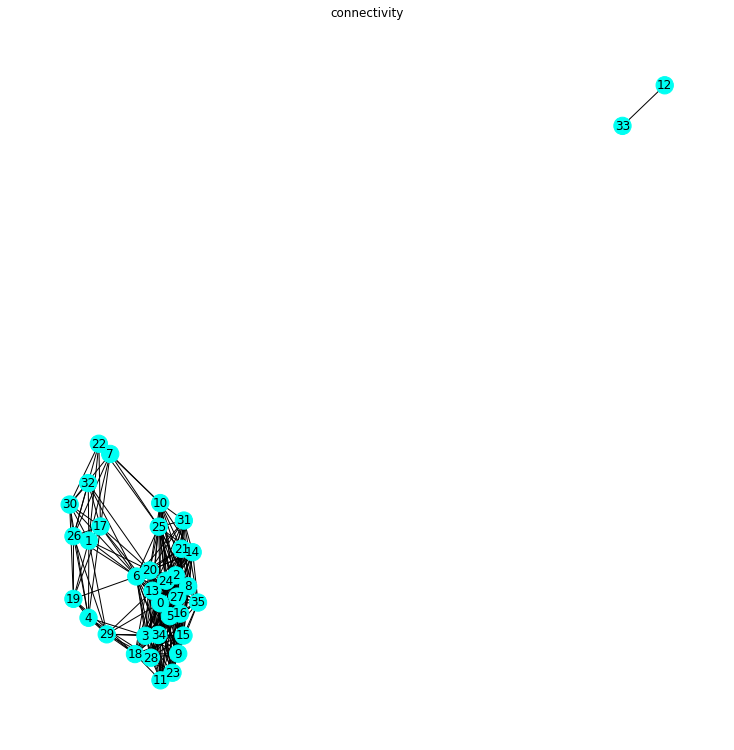

In [5]:
import networkx as nx
import matplotlib.pyplot as plt
from visibility_utils import generate_distinct_colors

regs = regions#+regions_poi
connectivity_graph = nx.Graph()
for idx in range(len(regs)):
    connectivity_graph.add_node(idx)


for idx1 in range(len(regs)):
    for idx2 in range(idx1 +1, len(regs)):
        r1 = regs[idx1]
        r2 = regs[idx2]
        if r1.IntersectsWith(r2):
            connectivity_graph.add_edge(idx1,idx2)

largest_con_comp = list(list(nx.connected_components(connectivity_graph))[0])
regions_connected_component = [regs[i] for i in largest_con_comp]

fig = plt.figure(figsize=(10,10))
hues = generate_distinct_colors(2+1)[1:]
colors = []
#for g, h in zip([regions, regions_poi], hues):
for g, h in zip([regions], hues):

    colors += [h]*len(g)

nx.draw_spring(connectivity_graph, 
                with_labels = True, 
                node_color = colors)
plt.title(f"connectivity")

In [6]:
def conversion_dummy(q):
    return q
import dijkstraspp
dspp = dijkstraspp.DijkstraSPPsolver(regions, conversion_dummy)
# import pickle
# with open(exp_name+"_dspp.pkl", 'rb') as f:
#     dspp = pickle.load(f)

[DijkstraSPP] Pre-Building adjacency matrix  0 / 36
[DijkstraSPP] Pre-Building adjacency matrix  10 / 36
[DijkstraSPP] Pre-Building adjacency matrix  20 / 36
[DijkstraSPP] Pre-Building adjacency matrix  30 / 36
[DijkstraSPP] Pre-Building d-adjacency matrix  0 / 288


In [7]:
# import pickle
# dsppname = exp_name+"_dspp.pkl"
# with open(dsppname, 'wb') as f:
#     pickle.dump(dspp, f)

In [8]:
from pydrake.all import Mesh
a = Mesh('display_signs/5dofsign.gltf')
meshcat.SetObject('/instructionsign', a)
meshcat.SetTransform('/instructionsign',RigidTransform(
                            RotationMatrix.MakeZRotation(-np.pi/2)@RotationMatrix.MakeXRotation(-np.pi/2), 
                            np.array([0, 12 , 0])))

In [9]:
import time
centers = [r.ChebyshevCenter() for r in regions]
meshcat.SetProperty(f"/Grid", "visible", False)
meshcat.SetProperty(f"/drake/visualizer/shunk", "visible", False)

np.random.seed(10)
start = centers[0]

frame_time = 1/32.0
cur_time = 0
meshcat.StartRecording()
animation = meshcat.get_mutable_recording()
frame = 0
for _ in range(50):
    #nxt = vs.sample_in_regions() #
    while True:
        nxt_ = sample_cfree(1, 1000, [])[0]
        if point_in_regions(nxt_, regions):
            nxt = nxt_.squeeze()
            break
        # nxt = centers[np.random.choice(len(centers))] #sample_cfree(1, 1000, [])[0].reshape(-1,1)#
        # #plot_endeff_pose(nxt, str(0))
        # if nxt.squeeze()[0] != start.squeeze()[0]:
        #     break
    print(f"start {start} next {nxt}")

    wp, dist = dspp.solve(start, nxt, refine_path=True)#dijkstra_spp(start, nxt, node_intersections, base_ad_mat, vs.regions, point_conversion, optimize= True)
    print(dist)
    hide_traj("/iris/points/traj/",animation ,frame)
    #if dist >0:
    dense_waypoints = densify_waypoints(wp, densify=30)
    dense_waypoints_plt = densify_waypoints(wp, densify=90)
    #plot_endeff_traj(dense_waypoints_plt)
    print(len(dense_waypoints))
    for qa in dense_waypoints:
        anim_endeff_traj(dense_waypoints_plt, animation, frame)
        #qa = #Ratfk.ComputeQValue(ta, np.zeros(3))
        showres(qa)
        diagram_context.SetTime(cur_time)
        if col_func_handle_(qa):
            print('col')
            # for idx, r in enumerate(regions_connected_component):
            #     if point_in_regions(qa, [r]):
            #         print(f"collision in region {largest_con_comp[idx]}")
            #break
        cur_time+=frame_time
        frame+=1
        #time.sleep(0.003)
    start = nxt.copy()
        #time.sleep(0.01)
        
        # meshcat.Delete("/iris/points/traj/")
        
    

nxt = centers[0]
wp, dist = dspp.solve(start, nxt, refine_path=True)#dijkstra_spp(start, nxt, node_intersections, base_ad_mat, vs.regions, point_conversion, optimize= True)
print(dist)
hide_traj("/iris/points/traj/",animation ,frame)
if dist >0:
    dense_waypoints = densify_waypoints(wp, densify=30)
    dense_waypoints_plt = densify_waypoints(wp, densify=100)
    #plot_endeff_traj(dense_waypoints_plt)
    for qa in dense_waypoints:
        anim_endeff_traj(dense_waypoints_plt, animation, frame)
        #qa = #Ratfk.ComputeQValue(ta, np.zeros(3))
        showres(qa)
        diagram_context.SetTime(cur_time)
        if col_func_handle_(qa):
            print('col')
            # for idx, r in enumerate(regions_connected_component):
            #     if point_in_regions(qa, [r]):
            #         print(f"collision in region {largest_con_comp[idx]}")
            #break
        cur_time+=frame_time
        frame+=1
        #time.sleep(0.003)

from pydrake.all import MeshcatAnimation
meshcat.StopRecording()
animation.set_autoplay(True)
#animation.set_loop_mode(MeshcatAnimation.LoopMode(2))
meshcat.PublishRecording()
with open("static_htmls/5DOFUR5_arxiv.html", "w+") as f:
    f.write(meshcat.StaticHtml())

start [ 1.23593407 -1.28998618 -1.30240091 -1.03184387 -0.30360355] next [ 1.53428209 -2.71008388  0.75576296  1.40695281 -0.00844265]
[DijkstraSPP] optimized distance/ start-distance = 3.52 / 3.52 = 1.00
3.51803591997863
11
start [ 1.53428209 -2.71008388  0.75576296  1.40695281 -0.00844265] next [-1.55623831 -1.70741427  1.47326647 -1.87113414 -2.32788351]
[DijkstraSPP] optimized distance/ start-distance = 6.66 / 8.20 = 0.81
6.657535279464993
69
start [-1.55623831 -1.70741427  1.47326647 -1.87113414 -2.32788351] next [ 0.24058273 -2.02348071 -0.71624113  0.98470239 -0.32892565]
[DijkstraSPP] optimized distance/ start-distance = 4.69 / 7.37 = 0.64
4.685481552408123
37
start [ 0.24058273 -2.02348071 -0.71624113  0.98470239 -0.32892565] next [-0.34152433 -1.88758238  0.03946322  1.80410531 -2.31789181]
[DijkstraSPP] optimized distance/ start-distance = 2.36 / 2.36 = 1.00
2.357077335732448
16
start [-0.34152433 -1.88758238  0.03946322  1.80410531 -2.31789181] next [ 0.32399789 -0.64966729